# Part 0:
## import everything
Run the cell below

In [ ]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")
import sys
import pickle
import string
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import PyPDF2 as ppdf
from scipy import stats
from scipy.ndimage.filters import gaussian_filter as smooth
import matplotlib.animation as animation
import matplotlib.backends.backend_pdf
import mpl_toolkits.axes_grid1.inset_locator as inset
from matplotlib.ticker import FormatStrFormatter, MaxNLocator, ScalarFormatter, FuncFormatter
from matplotlib.patches import ConnectionPatch, FancyArrowPatch
from set_rc_params import set_rc_params
import ROOT


if "__file__" not in dir():
    %matplotlib inline
    %config InlineBackend.close_figures = False

    root=ROOT.root
    
    ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
    CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
    CWD=os.getcwd()
    os.chdir(CommonNoteBookesPath)
    %run UtilityTools.ipynb
    %run Animal_Tags.ipynb
    %run loadRat_documentation.ipynb
    %run Lesion_Size.ipynb
    %run plotRat_documentation_1_GeneralBehavior.ipynb
    %run plotRat_documentation_3_KinematicsInvestigation.ipynb
    %run RunBatchRat_3_CompareGroups.ipynb
    %run BatchRatBehavior.ipynb
    currentNbPath=os.path.join(os.path.split(ThisNoteBookPath)[0],'LesionPaper','Task_Example_Group.ipynb')
    %run $currentNbPath

    os.chdir(CWD)

    logging.getLogger().setLevel(logging.ERROR)
    
    param={
        "goalTime":7,#needed for pavel data only
        "treadmillRange":[0,90],#pavel error conversion "treadmillRange":[0,80]
        "maxTrialDuration":15,
        "interTrialDuration":10,#None pavel
        "endTrial_frontPos":30,
        "endTrial_backPos":55, 
        "endTrial_minTimeSec":4,
        "cameraSamplingRate":25, #needed for new setup    

        "sigmaSmoothPosition":0.1,#0.33, 0.18 pavel
        "sigmaSmoothSpeed":0.3,#0.3, 0.5 pavel
        "nbJumpMax":100,#200 pavel
        "binSize":0.25,
        #parameters used to preprocess (will override the default parameters)
    }
    Y1,Y2=param['treadmillRange']

    print('os:',OS(),'\nroot:',root,'\nImport successful!')

---
---


# part 1:

# DEFINITIONS

### If you don't know what to do, move to part 2

In [ ]:
def add_panel_caption(axes: tuple, offsetX: tuple, offsetY: tuple, **kwargs):
    """
    This function adds letter captions (a,b,c,d) to Axes in axes
    at top left, with the specified offset, in RELATIVE figure coordinates
    """
    assert len(axes)==len(offsetX)==len(offsetY), 'Bad input!'
    
    fig=axes[0].get_figure()
    fbox=fig.bbox
    for ax,dx,dy,s in zip(axes,offsetX,offsetY,string.ascii_uppercase):
        axbox=ax.get_window_extent()
    
        ax.text(x=(axbox.x0/fbox.xmax)-abs(dx), y=(axbox.y1/fbox.ymax)+abs(dy),
                s=s,fontweight='extra bold', fontsize=10, ha='left', va='center',
               transform=fig.transFigure,**kwargs)

---

plotting the trajectories of example sessions

In [ ]:
def plot_session_median_trajectory(data,ax):
    posDict=data.position
    maxL=np.nanmax(list(data.stopFrame.values()))
    maxL=int(maxL)
    position=np.ones((maxL,len(posDict.keys())))*np.nan
    time=np.arange(-data.cameraToTreadmillDelay,
                   (maxL-data.cameraSamplingRate)/data.cameraSamplingRate,
                   1/data.cameraSamplingRate)
    
    
    for i,trial in enumerate(posDict):
        pos=posDict[trial][:data.stopFrame[trial]]
        position[:len(pos),i]=pos
    
    #keeping data where 70% of points exist
    nanSum=np.sum(np.isnan(position),axis=1)
    try:
        maxTraj=np.where(nanSum>.3*position.shape[1])[0][0]
    except IndexError:
        maxTraj=position.shape[1]
    
    
    ax.plot(time[:maxTraj], np.nanmedian(position,axis=1)[:maxTraj], color='navy', lw=2)    

def plot_trajectories(data,ax):
    posDict=data.position
    time=data.timeTreadmill #align on camera
    
    seqTrials,_=sequentialTrials(data)._compute_sequential_trials()
    
    Colors=[]
    for trial in posDict:
        color="steelblue"
        alpha=1
        zorder=1
        if trial not in seqTrials:
            color="salmon"
            alpha=1
            zorder=0
        Colors.append(color)
        _End=int(data.cameraSamplingRate*data.entranceTime[trial])+ \
        int(data.cameraSamplingRate*data.cameraToTreadmillDelay)+1
        ax.plot(time[trial][:_End], posDict[trial][:_End],
               color=color, lw=.5, alpha=alpha, zorder=zorder)
            
#     ax.fill_betweenx(y=(0,90),x1=0,x2=7, facecolor='gray', edgecolor=None, alpha=.4)
    
    return np.array(Colors)



def plot_trajectories_and_distributions(root, ax, session, showText=True):
    data=Data(root,session[:6],session,redoPreprocess=False)
    
    color=plot_trajectories(data,ax=ax)
    
    position=get_positions_array_beginning(data,onlyGood=False,raw=False)
    position=position.T
    
#     plot_session_median_trajectory(data,ax)
    
#     props={'color':'k', 'linewidth':1}
#     ax.boxplot(x=data.entranceTime,whis=[25,75],vert=False,
#                positions=[5], widths=5,
#                showcaps=False, showfliers=False,
#                medianprops=props, boxprops=props, whiskerprops=props, zorder=5
#               )
    
    if showText:
        ax.set_xlim([-1,11])
        ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
        ax.set_xticklabels([0,'','','','','','',7,'','','',11])
        ax.set_ylim([0,90])
        ax.set_yticks([0,10,20,30,40,50,60,70,80,90])
        ax.set_yticklabels([0,'','','','','','','','',90])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_bounds(0,11)
        ax.set_xlabel('Trial time (s)',labelpad=0)
        ax.set_ylabel('Position (cm)',labelpad=-8)
    else:
        ax.set_xlim([-1,11])
        ax.set_ylim([0,90])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.tick_params(bottom=False, top=False, left=False, right=False,
                      labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    
#======================================
def plot_pre_post_traj(root, gs, animal, preProfile, postProfile, preSession, postSession, showText=False):
    
    assert len(preSession)+len(postSession) == gs.get_geometry()[1]
    axes=[]
    
    sessionList=batch_get_session_list(root, animalList=[animal], profile=preProfile)['Sessions']
    for i,sessionId in enumerate(preSession):
        session=sessionList[sessionId]
        ax= gs.figure.add_subplot(gs[i])
        plot_trajectories_and_distributions(root, ax, session, showText=i==1 and showText)
        axes.append(ax)
    
    sessionList=batch_get_session_list(root, animalList=[animal], profile=postProfile)['Sessions']
    for j,sessionId in enumerate(postSession):
        session=sessionList[sessionId]
        ax= gs.figure.add_subplot(gs[i+j+1])
        plot_trajectories_and_distributions(root, ax, session,showText=False)
        axes.append(ax)
    
    return axes

In [ ]:
if "__file__" not in dir():
    #the inputs
    fig=plt.figure(figsize=(8,1.5))
    gs= fig.add_gridspec(nrows=1, ncols=4, left=0.02, bottom=0.02, right=0.98, top=.98, wspace=.1)
    

    
    profile1pre={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Control']
             }
    
    profile1post={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Control-AfterBreak']
             }
    animalList1Ctrl='Rat250'
    
    sessionIndex1pre =(0,-1)
    sessionIndex1post=(0,-1)
    
    plot_pre_post_traj(root, gs, animalList1Ctrl, profile1pre, profile1post, sessionIndex1pre, sessionIndex1post)
    gs.figure.add_artist(ConnectionPatch(xyA=(.5,0), xyB=(.5,1), coordsA='figure fraction', coordsB='figure fraction',
                                     ls='--',lw=2))

    
    plt.show()
    plt.close('all')

---

plotting the predefined image

In [ ]:
def plot_animal_image(ax, animal):
    PATHS=('/NAS02/Rat250/Histology/DLS_25.jpg',
           '/NAS02/Rat217/Histology/DS_35.jpg',
           '/NAS02/Rat304/Histology/DS_35.jpg')
    
    try:
        filePath=[path for path in PATHS if animal in path][0]
    except IndexError:
        logging.error(f'Bad Animal name ({animal}), path not defined!')
        return
    
    f=PIL.Image.open(filePath)
    f.thumbnail((500,500),PIL.Image.ANTIALIAS)
    ax.imshow(f)

---

plotting group bar plots

In [ ]:
def plot_event_rec(root, ax, Profiles, badAnimals=None, TaskParamToPlot='% good trials', shift=0,
                   nPre=5, nPost=10, **kwarg):

    if badAnimals is None:
        badAnimals=[]
    
    #getting the data
    animalList,SessionDict=event_detect(root, Profiles[0], Profiles[1], badAnimals=badAnimals)
    SessionDict={animal:SessionDict[animal] for animal in animalList}
    Results,nSessionPre,nSessionPost=event_statistic2(root,
                                                      SessionDict,
                                                      parameter=param,
                                                      redo=False,
                                                      TaskParamToPlot=[TaskParamToPlot])

    assert nPre<=nSessionPre and nPost<=nSessionPost,"fewer sessions available than requested:"
    
    data=np.array(list(Results[TaskParamToPlot].values()))
    
    xData=np.append(np.arange(-nPre,0),np.arange(1,nPost+1))

    groupData=np.nanmedian(data,axis=0)
    
    groupErr=np.nanpercentile(data,(25,75),axis=0)
    
    #plotting the errorbar
    ax.errorbar(xData + shift, groupData[nSessionPre-nPre:nSessionPre+nPost],
                abs(groupErr-groupData)[:,nSessionPre-nPre:nSessionPre+nPost],
                fmt='-o', zorder=5, ms=2, elinewidth=1,alpha=.8, **kwarg)
    
    def _tik(x,pos):
        if x in [-nPre,-1,1,nPost]:
            return ('$%+g$' if x>0 else '$%g$')%x
        else:
            return ''
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(_tik))
    
    ax.set_xlim([-nPre-.4,nPost+.4])
    ax.spines['bottom'].set_bounds(-nPre,nPost)
    ax.set_xticks(xData)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([0,100])
    ax.set_ylabel(TaskParamToPlot)
#     ax.set_xlabel('Sessions relative to break / lesion')

    return data[:,nSessionPre]


def add_legend_for_lesion_types(ax,N):
    r_marker = matplotlib.lines.Line2D([], [], color=[0,0,0,0],
                                       markeredgecolor='xkcd:orange', marker='o',
                                       markerfacecolor='xkcd:orange', markersize=3, label=f'DLS\n$n={N[0]}$')
    b_marker = matplotlib.lines.Line2D([], [], color=[0,0,0,0],
                                       markeredgecolor='purple', marker='o',
                                       markerfacecolor='purple', markersize=3, label=f'DMS\n$n={N[1]}$')
    m_marker = matplotlib.lines.Line2D([], [], color=[0,0,0,0],
                                       markeredgecolor='xkcd:green', marker='o',
                                       markerfacecolor='xkcd:green', markersize=3, label=f'DS\n$n={N[2]}$')


    leg=ax.legend(handles=[r_marker,b_marker,m_marker],loc=(0,-.02),mode='expand',ncol=3,
                  facecolor=None,edgecolor=None, fontsize=5,frameon=False)
    return leg

In [ ]:
if "__file__" not in dir():

    profile1={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'10',
              'Speed':'10',
              'Tag':['Control','Control-BackTo10','Control-Late-BackTo10']
              }
    profile2={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'10',
              'Speed':'10',
              'Tag':['Control-AfterBreak']
              }

    #number of sessions to plot
    badAnimals=['RatBAD']
    TaskParamToPlot="% good trials"
    wspace=0.05
    
    
    Profiles=(profile1,profile2,)
    plt.close('all')
    fig=plt.figure(figsize=(5,4))
    ax=fig.add_subplot(111)

    a=plot_event_rec(root, ax, Profiles,color='k',shift=-.1*.25)
    ax.set_ylim([0,100])

---

plotting group double errorbars for speed 

In [ ]:
def plot_event_1on1(root, ax, Profiles, colorCode, badAnimals=None, TaskParamToPlot='% good trials',
                   x_pos=None, nPre=slice(-3,None), nPost=slice(0,3),nFin=slice(3,6),
                    seed=1, animal_plot=True):
    if badAnimals is None:
        badAnimals=[]
    
    if x_pos is None:
        diff=.5
        x_c=.5
        x_pos=(x_c-diff,x_c+diff,x_c+3*diff)
    diff=x_pos[1]-x_pos[0]
    
    #getting the data
    animalList,sessionDict=event_detect(root, Profiles[0], Profiles[1], badAnimals=badAnimals)
    
    data=np.empty((len(animalList),3))
    for i,animal in enumerate(animalList):
        preSession,postSession=sessionDict[animal][0], sessionDict[animal][1]
        out=animal_learning_stats(root, animal, PerfParam=TaskParamToPlot,
                                  goodSessions=[*preSession,*postSession],redo=False)
        
        data[i,0]=np.nanmedian(out[:len(preSession)][nPre])
        data[i,1]=np.nanmedian(out[len(preSession):][nPost])
        data[i,2]=np.nanmedian(out[len(preSession):][nFin])
        
            
    
    y=np.nanpercentile(data,50,axis=0)
    yerr=np.nanpercentile(data,(25,75),axis=0)
    
    #plotting the errorbar
    ax.errorbar(x_pos, y, abs(yerr-y),fmt='o', zorder=5, ms=2, elinewidth=1, color='k')
    
    #plotting individual animals
    if animal_plot:
        np.random.seed(seed=seed)
        _coeff=50000
        for i in range(data.shape[0]):
            if np.any(np.isnan(data[i,:])):
                continue
            jitPre =np.random.uniform(low=x_pos[0]-diff/_coeff, high=x_pos[0]+diff/_coeff, size=1)
            jitPost=np.random.uniform(low=x_pos[1]-diff/_coeff, high=x_pos[1]+diff/_coeff, size=1)
            jitFin =np.random.uniform(low=x_pos[2]-diff/_coeff, high=x_pos[2]+diff/_coeff, size=1)
            
            _,tag=lesion_type(root,animalList[i])
            c=colorCode[tag] if tag in colorCode else 'gray'
            ax.scatter([jitPre,jitFin],data[i,[0,-1]], s=1, c=c, marker='o', edgecolors='none', alpha=.8)
#             ax.plot([jitPre,jitPost,jitFin],data[i,:], c=c, lw=.2, alpha=.4)
            ax.plot([jitPre,jitFin],data[i,[0,-1]], c=c, lw=.2, alpha=.4)

    ax.set_xlim([x_pos[0]-diff/4,x_pos[-1]+diff/4])
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['Before','Acute','Stable'])
    ax.xaxis.set_tick_params(rotation=70)
    ax.spines['bottom'].set_bounds(x_pos[0],x_pos[-1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#     ax.set_ylabel(TaskParamToPlot)
#     ax.set_xlabel('Sessions relative to lesion')

    return data,animalList

In [ ]:
if "__file__" not in dir():

    profile1={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Control', 'Control-AfterBreak', 'Control-Late-NoTimeout-BackToTimeout',
              'Control-NoTimeout-Control','Control-Sharp','IncReward-Late-Sharp',
              'Control-Sharp-AfterBreak','ImmobileTreadmill-Control']
             }
    profile2={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Late-Lesion_DMS','Late-Lesion_DS',
                    'Late-Lesion_DMS-Sharp','Late-Lesion_DLS','Late-Lesion_DS-Sharp']
             }

    #number of sessions to plot
    badAnimals=['RatBAD']
    TaskParamToPlot="Front Starting Trials"
    wspace=0.05
    
    
    Profiles=(profile1,profile2,)
    plt.close('all')
    fig=plt.figure(figsize=(5,4))
    ax=fig.add_subplot(111)

    ax.set_xticks([])
    data,animalList=plot_event_1on1(root, ax, Profiles, colorCode={'Control':'r'}, badAnimals=None, TaskParamToPlot=TaskParamToPlot,
                       x_pos=None, nPre=slice(-3,None), nPost=slice(0,3),nFin=slice(6,10),
                        seed=1, animal_plot=True)

---

Plot the definition of before after ...

In [ ]:
def plot_session_def(ax, sessionSlices= tuple()):
    eps=0
    xpos=ax.get_xticks()
    
    for sli in sessionSlices:
        assert isinstance(sli, slice), 'Bad Boy!'        
        stop=sli.stop
        if stop is None:
            stop=-1
        start=sli.start
        if start>=0:
            start+=1
#             stop+=1
        
        ax.axvspan(xmin=start+eps, xmax=stop-eps, zorder=-1, alpha=.8, ec= None,
                  color='xkcd:ivory')
        
    if len(sessionSlices)==3:
        for sli,String in zip(sessionSlices,['Before','Acute','Stable']):
            stop=sli.stop
            if stop is None:
                stop=-1
            start=sli.start
            if start>=0:
                start+=1
            
            mid=(start+stop)/2
            
            ax.text(mid,ax.get_ylim()[1],s=String,
                   fontsize='xx-small', ha='center',va='bottom')

In [ ]:
if "__file__" not in dir():

    plt.close('all')
    fig=plt.figure(figsize=(5,5))
    ax=fig.add_subplot(111)
    
    preSlice=slice(-3,None)
    postSlice=slice(0,3)
    finSlice=slice(3,6)
    
    SLICES=(preSlice,postSlice,finSlice)
    
    plt.xlim([-6,11])
    plot_session_def(ax,SLICES)
    

---

plot the underlined text

In [ ]:
def add_underlined_text_centered_at(fig,p1,p2, s):
    
    
    fig.add_artist(mpl.lines.Line2D([p1[0],p2[0]] , [p1[1],p2[1]],
                                    lw=1,color='k'))
    
    fig.add_artist(mpl.text.Text(x=np.mean([p1[0],p2[0]]), y=np.mean([p1[1],p2[1]]),
                                        text=s, c='k',
                                        ha='center',va='bottom',fontsize='x-small'))

In [ ]:
if "__file__" not in dir():

    plt.close('all')
    fig=plt.figure(figsize=(5,5))
    ax=fig.add_subplot(111)

    
    add_underlined_text_centered_at(fig,[.2,.5],[.7,.5],'test')
    
    
    plt.show()

---

plot Panel A

In [ ]:
def plot_panel_A(ax1,ax2,ax3,ax4,ax5):
    #learining curve
    profile=   {'Type':'Good',
                'rewardType':'Progressive',
                'initialSpeed':['10'],
                'Speed':'10',
                'Tag':['Control', 'Control-Sharp']}
    animalList= batch_get_animal_list(root,profile)
    NSession=30
    data=np.ones((NSession,len(animalList)))*np.nan
    for i,animal in enumerate(animalList):
        out=animal_learning_stats(root, animal, PerfParam='median entrance time (sec)',profile=profile)
        if len(out) < NSession:continue
        data[:,i]=out[:NSession]
    
    x=np.arange(1,NSession+1)
    y=np.nanmedian(data,axis=1)
    Gline=ax1.plot(x, y,color='xkcd:black')
    ax1.fill_between(x,y1=np.nanpercentile(data,25,axis=1),y2=np.nanpercentile(data,75,axis=1),
                    color='xkcd:gray')
    out=animal_learning_stats(root, 'Rat304', PerfParam='median entrance time (sec)',profile=profile)[:NSession]
    Eline=ax1.plot(x, out,'v',lw=1,ms=2,mfc='white',mec='k',markeredgewidth=.5)

    ax1.legend([*Gline,*Eline],[f'Group\n($n={np.sum(~np.isnan(data[1,:]))}$)','Example'],
               loc='lower right', fontsize=5,frameon=False,markerscale=2)
    ax1.axhline(y=7,linestyle='--', lw=.7, c='xkcd:darkgreen')
    ax1.set_xlim([0,NSession+1])
    ax1.spines['bottom'].set_bounds(0,NSession)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_ylim([1,8])
    ax1.set_yticks([1,2,3,4,5,6,7,8])
    ax1.set_yticklabels([1,'','','','','',7,8])
    ax1.tick_params('both', labelsize='xx-small',)
    ax1.set_xlabel('Learning session #',labelpad=0,fontsize='xx-small')
    ax1.set_ylabel('Entrance time (s)' ,labelpad=0,fontsize='xx-small')

    #Plot the %Routine
    data=np.ones((NSession,len(animalList)))*np.nan
    for i,animal in enumerate(animalList):
        out=animal_learning_stats(root, animal, PerfParam="Motor Sequence Score",profile=profile)
        if len(out) < NSession:continue
        data[:,i]=out[:NSession]
    
    x=np.arange(1,NSession+1)
    y=np.nanmedian(data,axis=1)
    ax4.plot(x, y,color='xkcd:black')
    ax4.fill_between(x,y1=np.nanpercentile(data,25,axis=1),y2=np.nanpercentile(data,75,axis=1),
                    color='xkcd:gray')
    out=animal_learning_stats(root, 'Rat304', PerfParam="Motor Sequence Score",profile=profile)[:NSession]
    ax4.plot(x, out,'v',lw=1,ms=2,mfc='white',mec='k',markeredgewidth=.5)

    ax4.set_xlim([0,NSession+1])
    ax4.spines['bottom'].set_bounds(0,NSession)
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.set_ylim([0,1])
    ax4.set_yticks(np.arange(0,1.01,.2))
    ax4.set_yticklabels([0]+['']*4+[100])
    ax4.tick_params('both', labelsize='xx-small',)
    ax4.set_xlabel('Learning session #',labelpad=0,fontsize='xx-small')
    ax4.set_ylabel('% Routine' ,labelpad=-7,fontsize='xx-small')

    #plot the sessions
    naive='Rat304_2018_10_08_15_54'
    pro  ='Rat304_2018_11_15_16_10'
    
    plot_trajectories_and_distributions(root, ax2, session=naive, showText=True)
    plot_trajectories_and_distributions(root, ax3, session=pro, showText=False)
    ax2.text(5.5,.1,'#1',
         va='bottom',ha='center',fontsize='xx-small')
    ax3.text(5.5,.1,'#30',
             va='bottom',ha='center',fontsize='xx-small')
    

    ax3.text(-1,0,'Routine trials',
         va='top',ha='left',fontsize=5, color='steelblue')
    ax3.text(-1,-8,'Other trials',
         va='top',ha='left',fontsize=5, color='salmon')

    
    ax2.tick_params('both', labelsize='xx-small',)
    ax3.tick_params('both', labelsize='xx-small',)
    ax2.set_ylabel('Position (cm)',fontsize='xx-small')
    ax2.set_xlabel('Trial time (s)',fontsize='xx-small')
    
    #Plot the SPEED
    data=np.ones((NSession,len(animalList)))*np.nan
    for i,animal in enumerate(animalList):
        out=animal_learning_stats(root, animal, PerfParam="Forward Running Speed",profile=profile)
        if len(out) < NSession:continue
        data[:,i]=out[:NSession]
    
    x=np.arange(1,NSession+1)
    y=np.nanmedian(data,axis=1)
    ax5.plot(x, y,color='xkcd:black')
    ax5.fill_between(x,y1=np.nanpercentile(data,25,axis=1),y2=np.nanpercentile(data,75,axis=1),
                    color='xkcd:gray')
    out=animal_learning_stats(root, 'Rat304', PerfParam="Forward Running Speed",profile=profile)[:NSession]
    ax5.plot(x, out,'v',lw=1,ms=2,mfc='white',mec='k',markeredgewidth=.5)

    ax5.set_xlim([0,NSession+1])
    ax5.spines['bottom'].set_bounds(0,NSession)
    ax5.spines['top'].set_visible(False)
    ax5.spines['right'].set_visible(False)
    ax5.set_ylim([20,80])
    ax5.set_yticks(np.arange(20,81,10))
    ax5.set_yticklabels([20]+['']*5+[80])
    ax5.tick_params('both', labelsize='xx-small',)
    ax5.set_xlabel('Learning session #',labelpad=0,fontsize='xx-small')
    ax5.set_ylabel('Speed (cm/s)' ,labelpad=-7,fontsize='xx-small')


In [ ]:
if "__file__" not in dir():
    plt.close('all')
    fig=plt.figure(figsize=(15,5))
    ax1=fig.add_subplot(151)
    ax2=fig.add_subplot(152)
    ax3=fig.add_subplot(153)
    ax4=fig.add_subplot(154)
    ax5=fig.add_subplot(155)
    
    plot_panel_A(ax1,ax2,ax3,ax4,ax5)

------



------

# part 2:

# GENERATING THE FIGURE

Definition of Parameters

In [ ]:
if "__file__" not in dir():
    # GENERAL PARAMS
    
    CtrlColor='gray'
    DLSColor='xkcd:orange'
    DMSColor='purple'
    DSColor='xkcd:green'
    
    ColorCode={'DS':DSColor,
               'DMS':DMSColor,
               'DLS':DLSColor,
               'Control':CtrlColor
              }
    
    colorSig='goldenrod'
    
    #===============================================

    # GRID 1 PARAMS
    
    
    sessionIndex1pre =(0,-1)
    sessionIndex1post=(0,5)
    

    
    #===============================================
    
    # GRID 2 PARAMS
    
    profile2pre={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Control-AfterBreak']
             }
    
    profile2post={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Late-Lesion_DLS']
             }
    
    animalList2Ctrl='Rat250'
    sessionIndex2post=(0,1)
    
    
    #================================================
    
    # GRID 3 PARAMS
    
    profile3pre={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Control-AfterBreak']
             }
    
    profile3post={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Late-Lesion_DMS']
             }
    
    animalList3Ctrl='Rat217'
    sessionIndex3post=(0,4)

    
    #================================================
    
    # GRID 4 PARAMS
    
    profile4pre={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Control-Sharp']
             }
    
    profile4post={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Late-Lesion_DS-Sharp']
             }
    
    animalList4Ctrl='Rat304'
    sessionIndex4post=(0,3)

    
    
    #===============================================
    
    # GRID 5 PARAMS
    
    TaskParamToPlot5='median entrance time (sec)'
    nPre5=5
    nPost5=10
    _s=.15
    ShiftDLS5 =-_s
    ShiftDMS5 =0*_s
    ShiftDS5  =_s
    
    
    profileCtrlPre5={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'10',
              'Speed':'10',
              'Tag':['Control','1Control-BackTo10','1Control-Late-BackTo10']
              }
    profileCtrlPost5={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'10',
              'Speed':'10',
              'Tag':['Control-AfterBreak']
              }  
    ProfilesCtrl5=(profileCtrlPre5,profileCtrlPost5,)
    
    profilePreLesion5={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':['10','0'],
              'Speed':'10',
              'Tag':['Control', 'Control-AfterBreak', 'Control-Late-NoTimeout-BackToTimeout', 'Control-NoTimeout-Control',
                     'Control-Sharp','IncReward-Late-Sharp','Control-Sharp-AfterBreak','ImmobileTreadmill-Control']
              }
    
    profileDLS5={'Type':'Good',
              'rewardType':'Progressive',
              'option':['not used', 'AsymmetricLesion'],
              'initialSpeed':['10','0'],
              'Speed':'10',
              'Tag':['Late-Lesion_DLS']
                 }
    profileDMS5={'Type':'Good',
              'rewardType':'Progressive',
              'option':['not used', 'AsymmetricLesion'],
              'initialSpeed':['10','0'],
              'Speed':'10',
              'Tag':['Late-Lesion_DMS','Late-Lesion_DMS-Sharp'],
                 }  
    profileDS5={'Type':'Good',
              'rewardType':'Progressive',
              'option':['not used', 'AsymmetricLesion'],
              'initialSpeed':['10','0'],
              'Speed':'10',
              'Tag':['Late-Lesion_DS','Late-Lesion_DS-Sharp']
                 }  

    ProfilesDLS5=(profilePreLesion5,profileDLS5,)
    ProfilesDMS5=(profilePreLesion5,profileDMS5,)
    ProfilesDS5 =(profilePreLesion5,profileDS5,)

    
    #================================================
    
    # GRID 6 PARAMS

    profileLesions6={'Type':'Good',
                     'rewardType':'Progressive',
                     'option':['not used', 'AsymmetricLesion'],
                     'initialSpeed':['0','10'],
                     'Speed':'10',
                     'Tag': list(set((*profileDLS5['Tag'], *profileDMS5['Tag'], *profileDS5['Tag'])))
                     }

    Profiles6=(profilePreLesion5,profileLesions6)
    TaskParamToPlot6="Forward Running Speed"
    preSlice6=slice(-2,None)
    postSlice6=slice(0,2)
    finSlice6=slice(8,10)
    
    


    #================================================
    
    # GRID 7 PARAMS
    
    TaskParamToPlot7="Motor Sequence Score"
    
    
    

    #===============================================
    
    # GRID 11 PARAMS
    
    TaskParamToPlot11="Forward Running Speed"


Plotting the figure

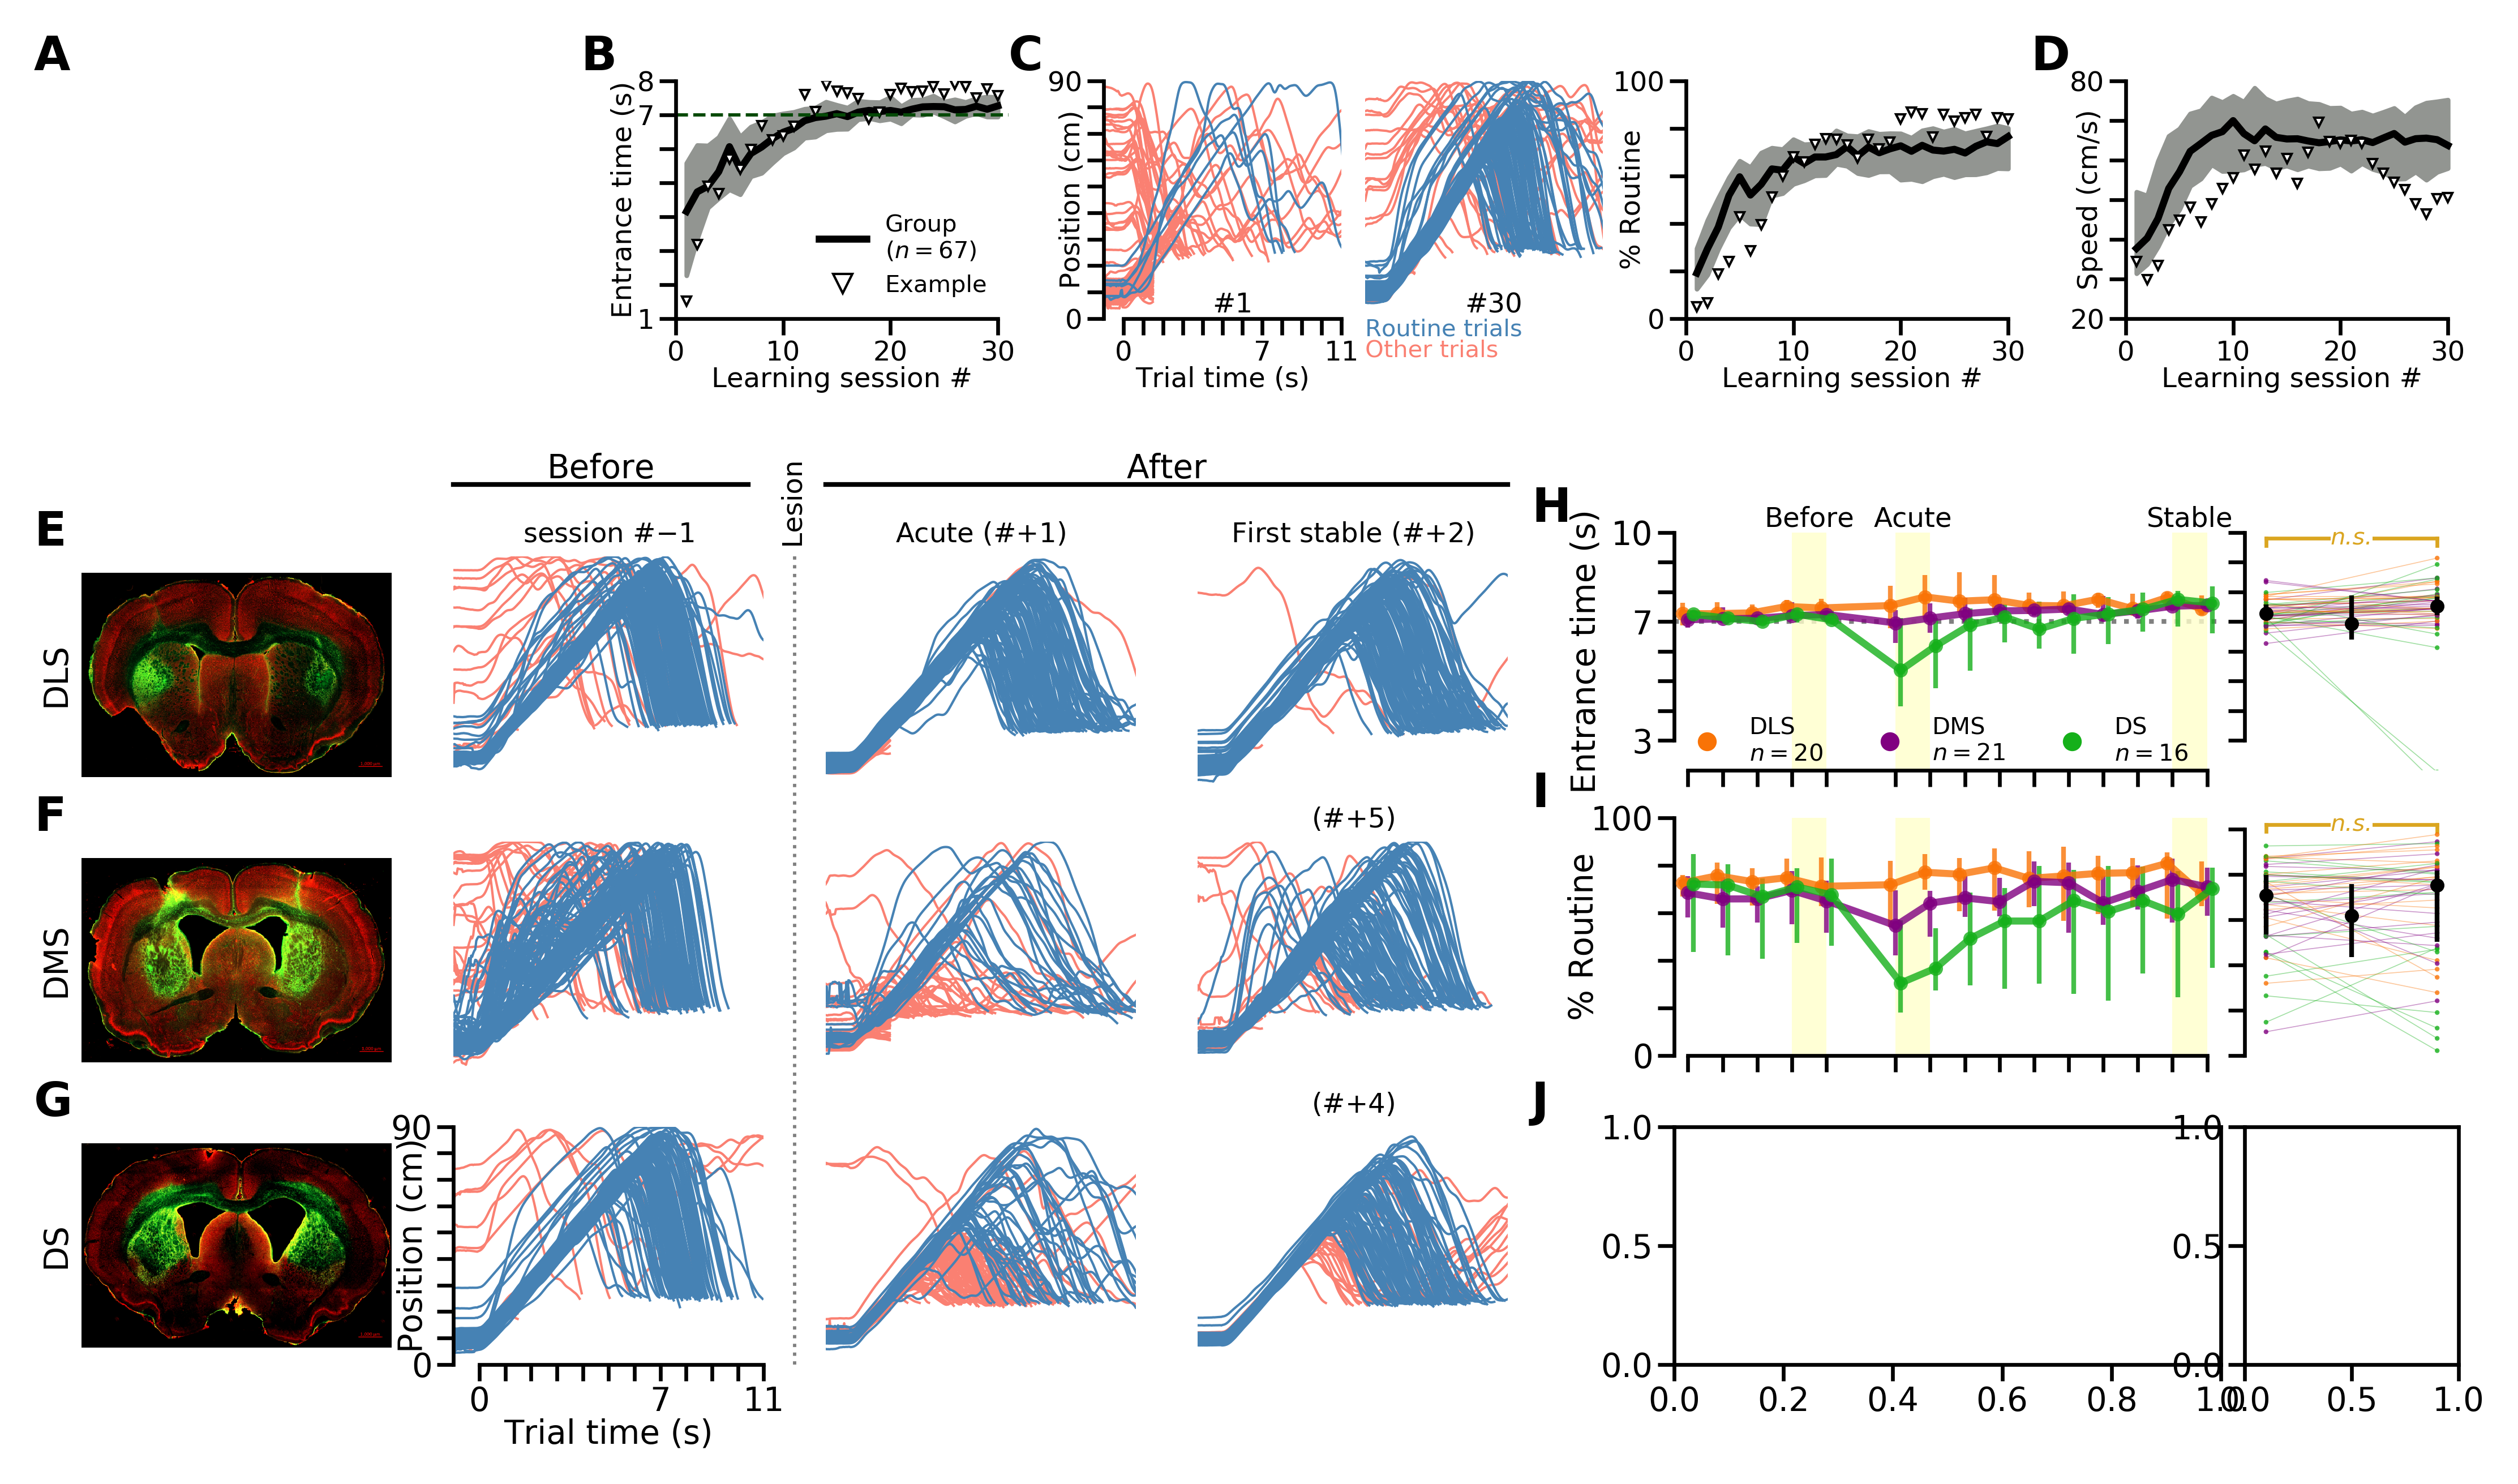

In [5]:
if "__file__" not in dir():
    plt.close('all')
    set_rc_params({'axes.labelsize':'x-small'})
    figsize=(7,7)
    fig=plt.figure(figsize=figsize,dpi=600)
    
   

    ##########################################
    # 1: task rules
    gs1   =fig.add_gridspec(nrows=1, ncols=1, left=0, bottom=0.6, right=.2, top=.74)
    ax1   =fig.add_subplot(gs1[0])
    gs1_   =fig.add_gridspec(nrows=1, ncols=1, left=.25, bottom=0.64, right=.39, top=.74)
    ax1_   =fig.add_subplot(gs1_[0])
    gs1__   =fig.add_gridspec(nrows=1, ncols=2, left=.43, bottom=0.64, right=.64, top=.74, wspace=.1)
    ax1__l  =fig.add_subplot(gs1__[0])
    ax1__r  =fig.add_subplot(gs1__[1])
    gs1___l   =fig.add_gridspec(nrows=1, ncols=1, left=.675, bottom=0.64, right=.815, top=.74)
    ax1___l  =fig.add_subplot(gs1___l[0])
    gs1___r   =fig.add_gridspec(nrows=1, ncols=1, left=.86, bottom=0.64, right=1, top=.74)
    ax1___r  =fig.add_subplot(gs1___r[0])

    
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

    
    plot_panel_A(ax1_,ax1__l,ax1__r,ax1___l,ax1___r)

    

    ##########################################
    # 2: DLS
    gs2= fig.add_gridspec(nrows=1, ncols=4, left=0, bottom=0.44, right=.6, top=.54)
    
    axes2=plot_pre_post_traj(root, gs2, animalList2Ctrl, profile2pre, profile2post, sessionIndex1pre, sessionIndex2post)
    
    axes2[0].clear()
    plot_animal_image(axes2[0], animalList2Ctrl)
    axes2[0].set_ylabel('DLS')
    axes2[1].set_title('session #$-1$',fontsize='xx-small')
    axes2[2].set_title('Acute (#$+1$)',fontsize='xx-small')
    axes2[3].set_title(f'First stable (#$+{sessionIndex2post[-1]+1}$)',fontsize='xx-small')
    
    #adding the Before and After text and line
    y_top=gs2.top+.03
    add_underlined_text_centered_at(fig,p1=(axes2[1].get_position().bounds[0],y_top),p2=(gs2.right/4+axes2[1].get_position().bounds[2],y_top), s='Before')
    add_underlined_text_centered_at(fig,p1=(axes2[2].get_position().bounds[0],y_top),p2=(gs2.right,y_top), s='After')
    
    
    
    ##########################################
    # 3: DMS
    gs3= fig.add_gridspec(nrows=1, ncols=4, left=0, bottom=0.32, right=.6, top=.42)
    
    axes3=plot_pre_post_traj(root, gs3, animalList3Ctrl, profile3pre, profile3post, sessionIndex1pre, sessionIndex3post)
    
    axes3[0].clear()
    plot_animal_image(axes3[0], animalList3Ctrl)
    axes3[0].set_ylabel('DMS')
    axes3[3].set_title(f'(#$+{sessionIndex3post[-1]+1}$)',fontsize='xx-small')
    


    
    
    ##########################################
    # 4: DS
    gs4= fig.add_gridspec(nrows=1, ncols=4, left=0, bottom=0.2, right=.6, top=.3)
    
    axes4=plot_pre_post_traj(root, gs4, animalList4Ctrl, profile4pre, profile4post, sessionIndex1pre, sessionIndex4post, showText=True)
    
    axes4[0].clear()
    plot_animal_image(axes4[0], animalList4Ctrl)
    axes4[0].set_ylabel('DS')
    axes4[3].set_title(f'(#$+{sessionIndex4post[-1]+1}$)',fontsize='xx-small')

    #add text and line
    x_=np.mean([gs4.right,gs4.left])
    fig.add_artist(mpl.lines.Line2D([x_,x_] , [gs4.bottom,gs2.top],
                                    linestyle=':',lw=.7,color='gray', zorder=1))
   
    fig.add_artist(mpl.text.Text(x=x_, y=gs2.top,
                                        text=' Lesion', c='k',
                                        ha='center',va='bottom',fontsize='xx-small',rotation=90))


    
    ##########################################
    # 5: % entrance time time course
    gs5= fig.add_gridspec(nrows=1, ncols=1, left=0.67, bottom=.45, right=0.9, top=.55)
    ax5= fig.add_subplot(gs5[0])
    
    #DLS
    xDLS5=plot_event_rec(root, ax5, ProfilesDLS5,TaskParamToPlot=TaskParamToPlot5,
                         nPre=nPre5, nPost=nPost5, color=DLSColor,shift=ShiftDLS5)

    #DMS
    xDMS5=plot_event_rec(root, ax5, ProfilesDMS5,TaskParamToPlot=TaskParamToPlot5,
                         nPre=nPre5, nPost=nPost5, color=DMSColor,shift=ShiftDMS5)

    #DS
    xDS5 =plot_event_rec(root, ax5, ProfilesDS5,TaskParamToPlot=TaskParamToPlot5,
                         nPre=nPre5, nPost=nPost5, color=DSColor,shift=ShiftDS5)

    
    add_legend_for_lesion_types(ax5,(len(xDLS5),len(xDMS5),len(xDS5)))
    
    ax5.axhline(y=7, ls=':',c='gray',lw=1, zorder=-5)
    ax5.set_ylim([2,10])
    ax5.spines['left'].set_bounds(3,10)
    ax5.set_yticks(np.arange(3,11))
    ax5.set_yticklabels([3,'','','',7,'','',10])
    ax5.set_ylabel('Entrance time (s)')
    ax5.set_xticklabels([])

    plot_session_def(ax5,sessionSlices=(preSlice6,postSlice6,finSlice6))


    
    
    
    ##########################################
    # 6: ET event plot
    gs6= fig.add_gridspec(nrows=1, ncols=1, left=0.91, bottom=.45, right=1, top=.55)
    ax6= fig.add_subplot(gs6[0])
    
    data6,*_=plot_event_1on1(root, ax6, Profiles6, colorCode=ColorCode, TaskParamToPlot=TaskParamToPlot5,
                             nPre=preSlice6, nPost=postSlice6,nFin=finSlice6)

    ax6.set_ylim([2,10])
    ax6.spines['left'].set_bounds(3,10)
    ax6.set_yticks(np.arange(3,11))
    ax6.set_yticklabels([])
    ax6.set_xticklabels([])
    ax6.spines['bottom'].set_visible(False)
    ax6.xaxis.set_visible(False)

    #STATS
    p6,s6=bootstrapTest(data6[:,-1]-data6[:,0])
    permtest.plotSigPair(ax6,y=9.8,x=(0,2), s=s6, color=colorSig,lw=.8)
    
    
    
    
    ##########################################
    # 7: % %Routine time course
    gs7= fig.add_gridspec(nrows=1, ncols=1, left=0.67, bottom=.33, right=0.9, top=.43)
    ax7= fig.add_subplot(gs7[0])
    
    #DLS
    xDLS7=plot_event_rec(root, ax7, ProfilesDLS5,TaskParamToPlot=TaskParamToPlot7,
                         nPre=nPre5, nPost=nPost5, color=DLSColor,shift=ShiftDLS5)

    #DMS
    xDMS7=plot_event_rec(root, ax7, ProfilesDMS5,TaskParamToPlot=TaskParamToPlot7,
                         nPre=nPre5, nPost=nPost5, color=DMSColor,shift=ShiftDMS5)

    #DS
    xDS7 =plot_event_rec(root, ax7, ProfilesDS5,TaskParamToPlot=TaskParamToPlot7,
                         nPre=nPre5, nPost=nPost5, color=DSColor,shift=ShiftDS5)

    
    plot_session_def(ax7,sessionSlices=(preSlice6,postSlice6))
    plot_session_def(ax7,sessionSlices=(finSlice6,))
    
    ax7.set_ylim([0,1])
    ax7.spines['left'].set_bounds(0,1)
    ax7.set_yticks(np.arange(0,1.1,.2))
    ax7.set_yticklabels([0]+['']*4+[100])
    ax7.set_ylabel('% Routine',labelpad=-2)
    ax7.set_xticklabels([])


    
    ##########################################
    # 8: %Routine event plot
    gs8= fig.add_gridspec(nrows=1, ncols=1, left=0.91, bottom=.33, right=1, top=.43)
    ax8= fig.add_subplot(gs8[0])
    
    data8,*_=plot_event_1on1(root, ax8, Profiles6, colorCode=ColorCode, TaskParamToPlot=TaskParamToPlot7,
                             nPre=preSlice6, nPost=postSlice6,nFin=finSlice6)

    ax8.set_ylim([0,1.05])
    ax8.spines['left'].set_bounds(0,1)
    ax8.set_yticks(np.arange(0,1.1,.2))
    ax8.set_yticklabels([])
    ax8.set_ylabel('')
    ax8.set_xticklabels([])
    ax8.spines['bottom'].set_visible(False)
    ax8.xaxis.set_visible(False)
    
    
    #STATS
    p8,s8=bootstrapTest(data8[:,-1]-data8[:,0])
    permtest.plotSigPair(ax8,y=1.02,x=(0,2), s=s8, color=colorSig,lw=.8)

    
    


    ##########################################
    # 11:  Speed time course
    gs11= fig.add_gridspec(nrows=1, ncols=1, left=0.67, bottom=.2, right=0.9, top=.30)
    ax11= fig.add_subplot(gs11[0])
 
    ##########################################
    # 12: SPEED event plot
    gs12= fig.add_gridspec(nrows=1, ncols=1, left=0.91, bottom=.2, right=1, top=.3)
    ax12= fig.add_subplot(gs12[0])
  
    

    
#     fig.align_ylabels([ax2,ax4,ax6])
    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    AXES=(ax1,ax1_,ax1__l,ax1___r,axes2[0],axes3[0],axes4[0],ax5,ax7,ax11)
    OFFX=np.array([.02]*len(AXES))
    OFFY=np.array([.01]*len(AXES))

    OFFX[[-3,-2,-1]]=0.06
    OFFX[[3,2,1]]=0.04
    
    add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)
    
    fig.savefig(os.path.join(os.path.dirname(os.getcwd()),'LesionPaper','Figures','Task_Example_Group.pdf'),
                format='pdf', bbox_inches='tight')
    
    thisPath  =os.path.join(os.path.dirname(os.getcwd()),'LesionPaper','Figures','Task_Example_Group.pdf')
    sketchPath=os.path.join(os.path.dirname(os.getcwd()),'LesionPaper','Figures','TreadmillSketch.pdf')
    if os.path.exists(sketchPath):
        f1=ppdf.PdfFileReader(thisPath).getPage(0)
        f2=ppdf.PdfFileReader(sketchPath).getPage(0)

        f1.mergeTranslatedPage(page2=f2, tx=15, ty=245, expand=False)

        writer=ppdf.PdfFileWriter()
        writer.addPage(f1)
        with open(thisPath,'wb') as f3:
            writer.write(f3)
    
    plt.show()
    plt.close('all')
    matplotlib.rcdefaults()